In [1]:
import numpy as np
import moviepy.editor as mp
from moviepy.editor import VideoFileClip

import matplotlib.pyplot as plt

In [2]:
DELTA = 0.01  # length of subclips to sample over
AUDIO_FPS = 44100

def get_clip_sample(clip, time_idx):
    '''
    This method takes the original clip, 
    grabs the subclip of length DELTA (in seconds) starting at time `time_idx` (seconds from start), 
    and returns an array representing the loudness of that subclip.
    
    The array can be 2D if the audio is stereo (vs mono). 
    The length of the array is determined by DELTA and the FPS rate of to_soundarray()
    '''
    return clip.audio.subclip(time_idx, time_idx+DELTA).to_soundarray(fps=AUDIO_FPS)

def get_average_volume(sound_arr):
    '''
    Returns the average volume of the audio clip given by the loudness array
    
    The array can be 1D or 2D without issue
    '''
    return np.sqrt(((1.0*sound_arr)**2).mean())

def get_sample_volume(clip, time_idx):
    '''
    Grabs the average volume of the subclip of length DELTA starting at time `time_idx`
    '''
    sample = get_clip_sample(clip, time_idx)
    return get_average_volume(sample)

def get_volume_array(clip):
    '''
    Takes as many samples of length DELTA across the duration of the clip
    and returns an array of those samples' average volumes
    '''
    return [get_sample_volume(clip, idx) for idx in np.arange(0, clip.audio.duration, DELTA)]

[(62, 64, 96), (1098, 1119, 1134), (1876, 1879, 1920), (2073, 2076, 2111), (2160, 2170, 2196)]
5


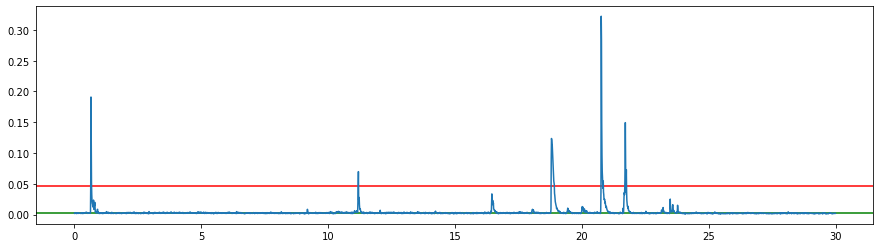

In [3]:
def sound_array_index_to_seconds(index):
    return index * DELTA

with VideoFileClip("./raw.MOV") as clip:
    clip = clip.subclip(0, 30) # TODO: remove this
    volumes = get_volume_array(clip)
    
    median = np.percentile(volumes, 50)
    top_perc = np.percentile(volumes, 99)
    
    top_indices = [idx for idx, vol in enumerate(volumes) if vol >= top_perc]
    
    top_slices = []
    for top_idx in top_indices:
        # check if already in a slice
        for min_idx, _, max_idx in top_slices:
            if top_idx >= min_idx and top_idx <= max_idx:
                break
        else:
            # populate new slice
            left_idx = top_idx-1
            while volumes[left_idx] > median:
                left_idx -= 1
            right_idx = top_idx+1
            while volumes[right_idx] > median:
                right_idx += 1
            top_slices.append((left_idx, top_idx, right_idx))
    
    print(top_slices)
    print(len(top_slices))
        
    
    plt.figure(figsize=(15, 4))
    plt.axhline(y=top_perc, color='r', linestyle='-')
    plt.axhline(y=median, color='g', linestyle='-')

    plt.plot([sound_array_index_to_seconds(idx) for idx in range(len(volumes))], volumes)
    plt.show()